### Limma analysis of Hydrogel dataset

2 Factor design: 

* Stiffness (Soft v Stiff) 
* Saha (yes, no) 

* 221511 naive overlap peaks 
* 3 biological replicates per Sample 

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [2]:
#load ATAC-seq raw read counts
data=read.table('hydrogel.soft.stiff.saha.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$Chrom,data$Start,data$End,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL

data=data[rowSums(data)>0,]


In [3]:
head(data)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3,saha_100Pa_Rep1,saha_100Pa_Rep2,saha_100Pa_Rep3,saha_2000Pa_Rep1,saha_2000Pa_Rep2,saha_2000Pa_Rep3
chr1_713708_714452,6,11,7,17,27,17,25,23,16,22,24,20
chr1_762643_763047,1,5,0,3,7,4,5,5,2,3,6,7
chr1_802987_803295,2,7,4,3,3,1,8,6,6,7,8,4
chr1_804984_805589,2,6,1,6,7,6,7,3,4,5,16,4
chr1_834765_835239,7,12,14,15,7,9,5,2,0,8,10,4
chr1_839144_839717,13,17,5,23,15,20,6,4,3,5,12,11


In [4]:
#load the metadata
batches=read.table("batches_hydrogel.soft.stiff.saha.txt",header=TRUE,sep='\t',row.names=1)
batches$Stiffness=factor(batches$Stiffness)
batches$Saha=factor(batches$Saha)
batches$Sample=factor(batches$Sample)


In [5]:
batches

,Stiffness,Saha,Sample
X100Pa_3D_Rep1,Soft,No,100Pa
X100Pa_3D_Rep2,Soft,No,100Pa
X100Pa_3D_Rep3,Soft,No,100Pa
X2000Pa_3D_Rep1,Stiff,No,2000Pa
X2000Pa_3D_Rep2,Stiff,No,2000Pa
X2000Pa_3D_Rep3,Stiff,No,2000Pa
saha_100Pa_Rep1,Soft,Yes,saha_100Pa
saha_100Pa_Rep2,Soft,Yes,saha_100Pa
saha_100Pa_Rep3,Soft,Yes,saha_100Pa
saha_2000Pa_Rep1,Stiff,Yes,saha_2000Pa


## Soft vs Stiff Analysis 


In [6]:
soft_stiff_data=data[,1:6]
soft_stiff_batches=batches[1:6,]

In [7]:
head(soft_stiff_data)
soft_stiff_batches

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chr1_713708_714452,6,11,7,17,27,17
chr1_762643_763047,1,5,0,3,7,4
chr1_802987_803295,2,7,4,3,3,1
chr1_804984_805589,2,6,1,6,7,6
chr1_834765_835239,7,12,14,15,7,9
chr1_839144_839717,13,17,5,23,15,20


,Stiffness,Saha,Sample
X100Pa_3D_Rep1,Soft,No,100Pa
X100Pa_3D_Rep2,Soft,No,100Pa
X100Pa_3D_Rep3,Soft,No,100Pa
X2000Pa_3D_Rep1,Stiff,No,2000Pa
X2000Pa_3D_Rep2,Stiff,No,2000Pa
X2000Pa_3D_Rep3,Stiff,No,2000Pa


In [8]:
soft_stiff_data=voom(counts=soft_stiff_data,normalize.method = "quantile")


In [10]:
data.pca=prcomp(t(soft_stiff_data$E))

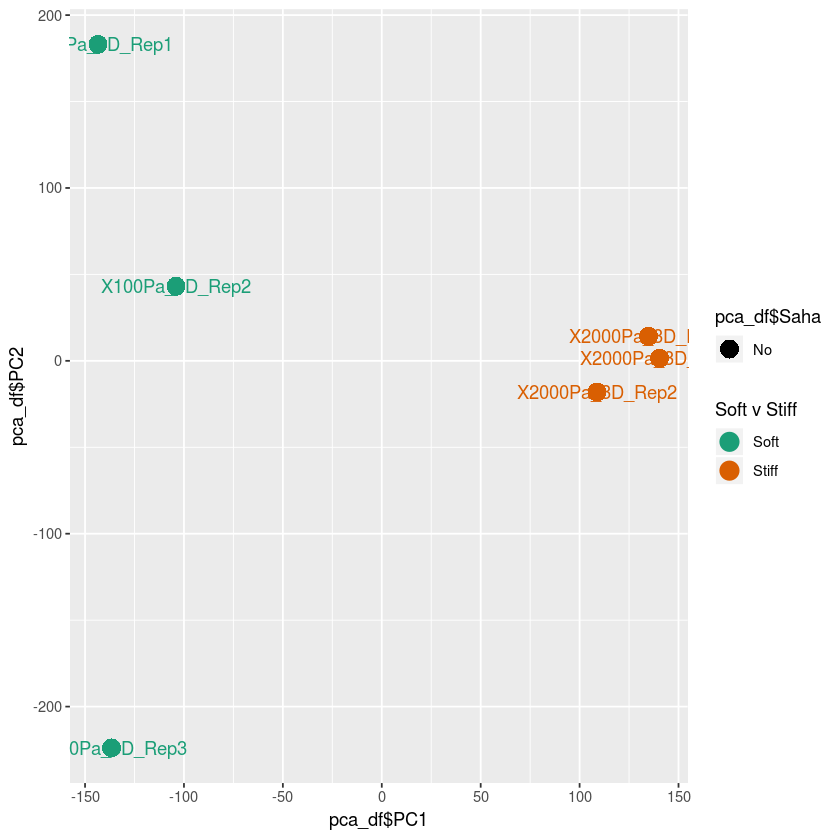

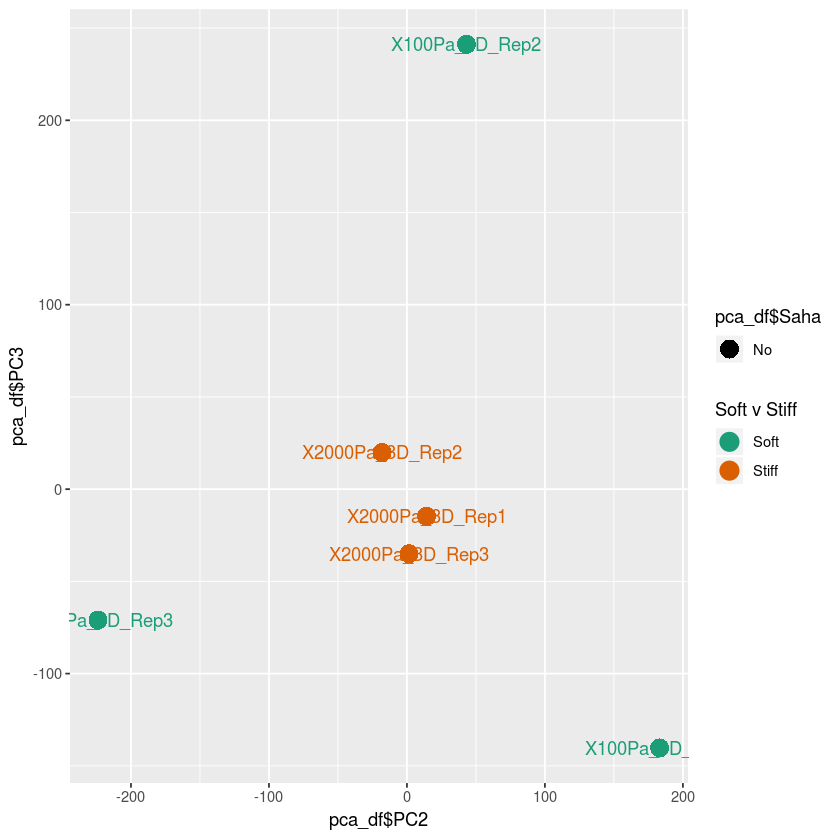

In [11]:
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)

pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,soft_stiff_batches)


p1=ggplot(data=pca_df,
         aes(x=pca_df$PC1,
            y=pca_df$PC2,
            label=rownames(pca_df),
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
geom_text()+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p1

p2=ggplot(data=pca_df,
         aes(x=pca_df$PC2,
            y=pca_df$PC3,
            label=rownames(pca_df),
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
geom_text()+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p2

In [12]:
pc1_loadings=sort(data.pca$rotation[, 1])
    upper_bound=mean(pc1_loadings)+2*sd(pc1_loadings)
    toselect=c(names(pc1_loadings[pc1_loadings>upper_bound]))
    heatmap_indices=match(toselect,rownames(soft_stiff_data$E))
    head(heatmap_indices)
    forheatmap=soft_stiff_data$E[heatmap_indices,]
    outfname=paste("pc1.limma.soft.stiff.highest.",2,'.tsv',sep='')
    write.table(forheatmap,file=outfname,row.names=TRUE,col.names=TRUE,sep='\t')

[1] 152005 136703 120090 196287  31927 135506

In [9]:
mod0=model.matrix(~1,data=soft_stiff_batches)
mod1=model.matrix(~0+Stiffness,data=soft_stiff_batches)
sva.obj=sva(soft_stiff_data$E,mod1,mod0)
sur_var=data.frame(sva.obj$sv)


Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

In [10]:

names(sur_var)=c("sv1","sv2")
soft_stiff_batches=cbind(soft_stiff_batches,sur_var)

In [11]:
full.design.sv=cbind(mod1,sur_var)


In [12]:
fit <- lmFit(soft_stiff_data$E,full.design.sv)


In [13]:
full.design.sv

,StiffnessSoft,StiffnessStiff,sv1,sv2
X100Pa_3D_Rep1,1,0,0.5689221,-0.709844909
X100Pa_3D_Rep2,1,0,-0.2793398,-0.073113703
X100Pa_3D_Rep3,1,0,0.5853991,0.697330177
X2000Pa_3D_Rep1,0,1,-0.3038324,-0.001360426
X2000Pa_3D_Rep2,0,1,-0.2951966,0.062465911
X2000Pa_3D_Rep3,0,1,-0.2759523,0.024522952


In [14]:
e=eBayes(fit)


In [15]:
hits=topTable(e,number=nrow(e),coef=2)

In [16]:
head(hits)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
chr20_26189689_26190566,7.753984,7.753984,36.03978,8.459787e-08,0.0001281771,8.064136
chr1_249131852_249133592,6.335028,6.312910,29.37573,2.619688e-07,0.0001281771,7.396263
chr1_221914745_221916898,6.331584,6.292591,29.31630,2.649152e-07,0.0001281771,7.388981
chr1_228352894_228354519,6.386219,6.295615,28.78990,2.927935e-07,0.0001281771,7.323252
chr8_103250669_103252103,6.198793,6.019393,28.75810,2.945855e-07,0.0001281771,7.319209
chr1_144931596_144933190,6.364021,6.365900,28.72233,2.966171e-07,0.0001281771,7.314652


In [17]:
normcounts=soft_stiff_data$E

#use limma's removeBatchEffect function 
tokeep=model.matrix(~Stiffness,data=soft_stiff_batches)
normcounts=removeBatchEffect(normcounts,design=tokeep,covariates = subset(soft_stiff_batches,select=c("sv1","sv2")))


write.table(normcounts,"soft_stiff_normcounts_from_limma.txt",quote=FALSE,sep='\t',col.names=TRUE,row.names=TRUE)


In [18]:
head(normcounts)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chr1_713708_714452,2.0815362,2.0651933,2.0585720,2.38036653,2.8431046,2.31988456
chr1_762643_763047,0.4310013,0.4100725,0.3843417,-0.41497680,0.5961430,-0.07561029
chr1_802987_803295,1.3396102,1.3061801,1.3419798,-0.08162177,-0.3321841,-1.39754259
chr1_804984_805589,0.8843182,0.8796004,0.8789866,0.66061152,0.7627111,0.61180077
chr1_834765_835239,2.3599025,2.3722845,2.4121732,2.36470736,1.1680974,1.56797684
chr1_839144_839717,2.5247567,2.5383564,2.5541972,2.70066248,2.0649580,2.50138085


## Visualizations 

In [19]:
#PCA on shifted log of normalized counts
normcounts[normcounts<0]=0 
lognorm=log2(normcounts+1)
data.pca=prcomp(t(lognorm))
#rld=assay(rlog(dds,blind=FALSE))
#data.pca=prcomp(t(rld))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)



In [20]:
var_explained_df

seq.1..length.var_explained..,var_explained
1,61.07
2,19.86
3,19.04
4,0.02
5,0.01
6,0.00


In [21]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,soft_stiff_batches)


In [22]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,Stiffness,Saha,Sample,sv1,sv2
X100Pa_3D_Rep1,-104.1020,2.4989763,1.0814602,2.724411607,1.38460711,-1.912441e-13,Soft,No,100Pa,0.5689221,-0.709844909
X100Pa_3D_Rep2,-103.6931,-0.4723061,-4.4350740,0.550360105,-2.17197212,4.583376e-13,Soft,No,100Pa,-0.2793398,-0.073113703
X100Pa_3D_Rep3,-103.5973,-6.6096024,-0.5955648,-3.275020993,0.78693313,-5.772658e-13,Soft,No,100Pa,0.5853991,0.697330177
X2000Pa_3D_Rep1,106.3479,-103.2437687,55.2026210,0.134217979,-0.03188799,-1.029083e-12,Stiff,No,2000Pa,-0.3038324,-0.001360426
X2000Pa_3D_Rep2,96.7559,101.4689634,63.2569794,-0.141791679,-0.02925352,1.179234e-12,Stiff,No,2000Pa,-0.2951966,0.062465911
X2000Pa_3D_Rep3,108.2886,6.3577374,-114.5104217,0.007822982,0.06157339,1.655755e-13,Stiff,No,2000Pa,-0.2759523,0.024522952


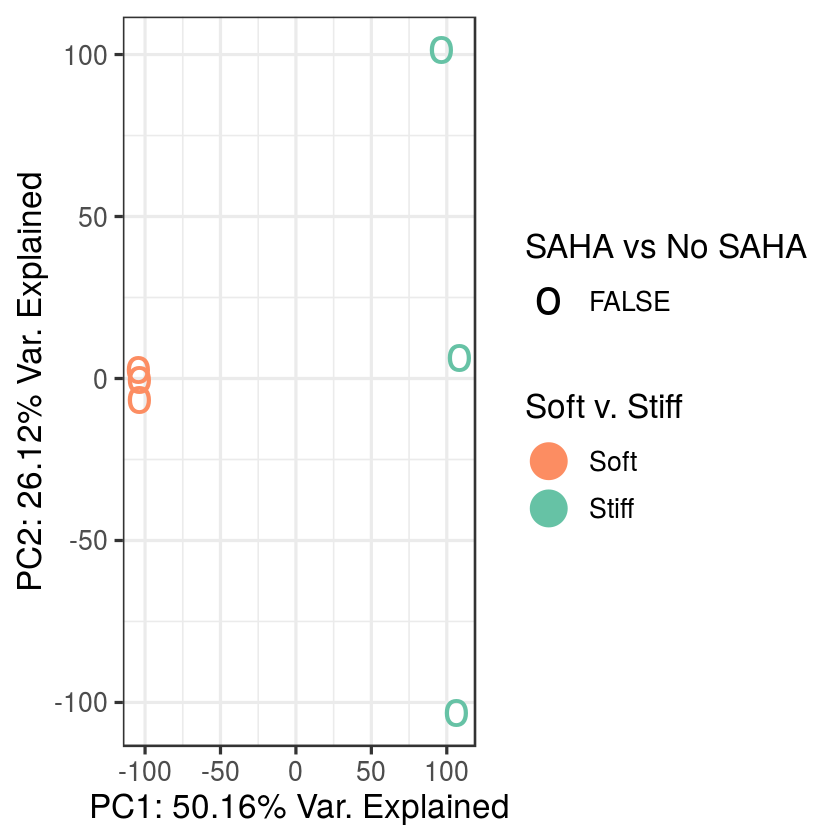

In [23]:
pca_df$Saha=c(FALSE,FALSE,FALSE,FALSE,FALSE,FALSE)
pca_df$Stiffness=c("Soft","Soft","Soft","Stiff","Stiff","Stiff")
pca_df$Saha=factor(pca_df$Saha)
p1=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Stiffness,shape=pca_df$Saha))+
  geom_point(size=10) +
  xlab("PC1: 50.16% Var. Explained")+
  ylab("PC2: 26.12% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c("#fc8d62","#66c2a5"),name="Soft v. Stiff")+
  scale_shape_manual(values=c("o","x"),name="SAHA vs No SAHA")
p1


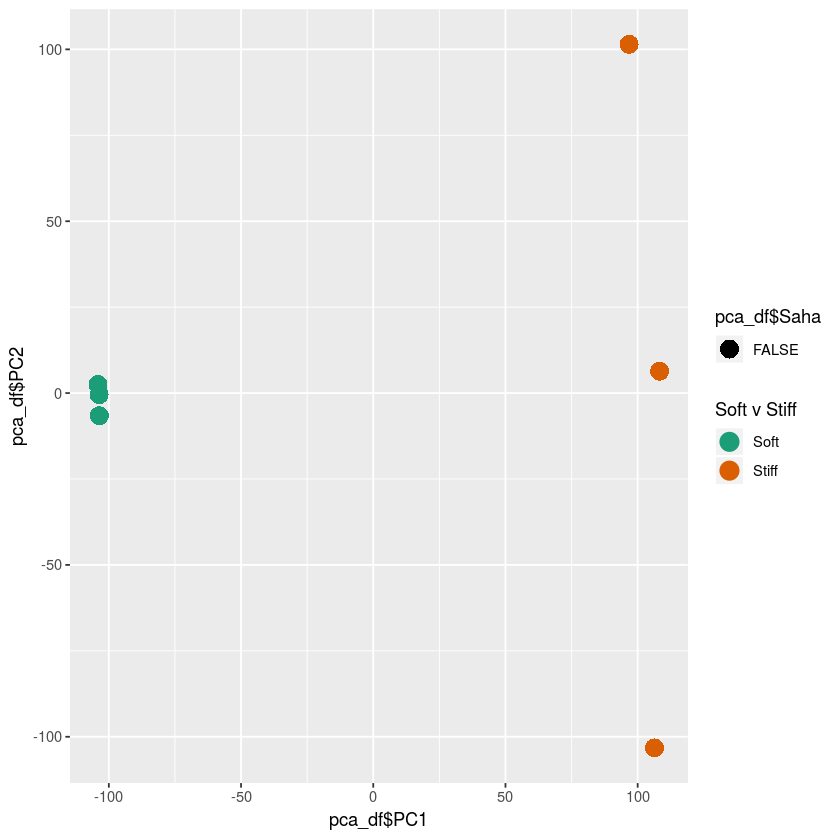

In [24]:
p1=ggplot(data=pca_df,
         aes(x=pca_df$PC1,
            y=pca_df$PC2,
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p1

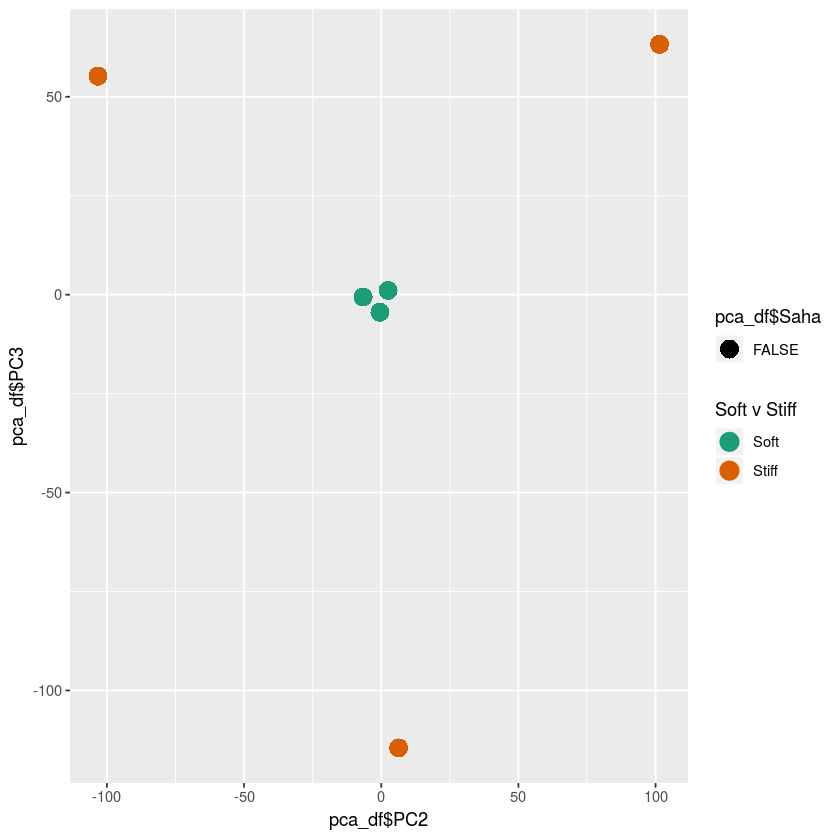

In [25]:
p2=ggplot(data=pca_df,
         aes(x=pca_df$PC2,
            y=pca_df$PC3,
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p2

## Get contributions to PC1 

In [26]:
pc1_loadings=sort(data.pca$rotation[, 1])

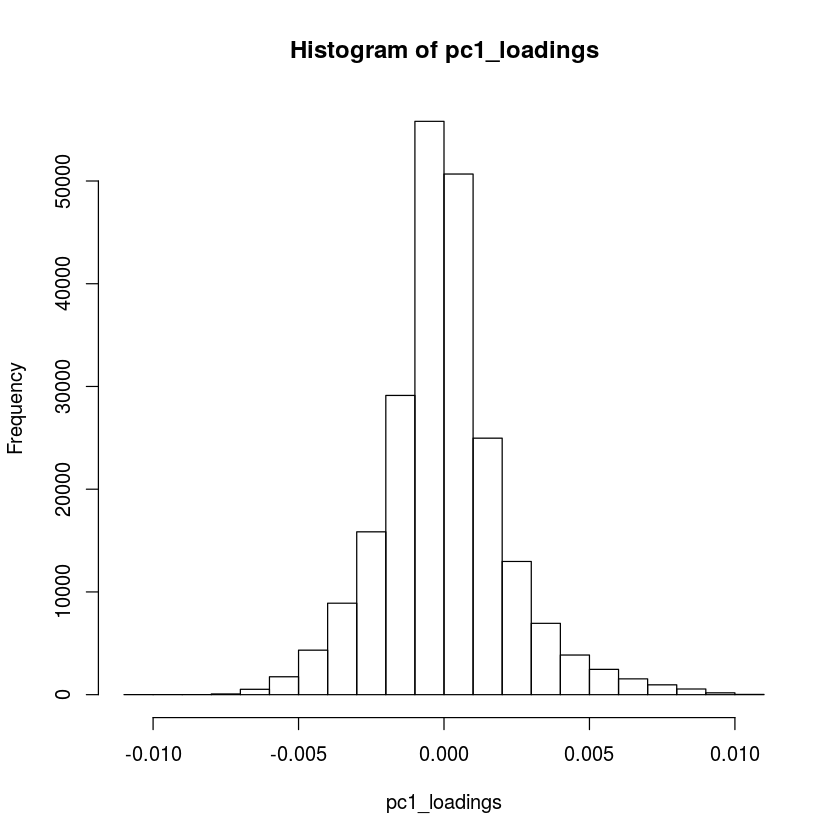

In [27]:
hist(pc1_loadings)

In [42]:
#lower_bound=mean(pc1_loadings)-3*sd(pc1_loadings)
upper_bound=mean(pc1_loadings)+3*sd(pc1_loadings)

In [43]:
#toselect=c(names(pc1_loadings[pc1_loadings<lower_bound]),names(pc1_loadings[pc1_loadings>upper_bound]))
toselect=c(names(pc1_loadings[pc1_loadings>upper_bound]))

In [44]:
#heatmap_indices=match(toselect,rownames(rld))
heatmap_indices=match(toselect,rownames(lognorm))
head(heatmap_indices)
forheatmap=lognorm[heatmap_indices,]

[1]  89518  37332 176434 171405  25538  93532

In [45]:
head(forheatmap)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chr18_25731418_25731854,0,0,0,1.7265988,1.436086,0.8288922
chr11_30149885_30150195,0,0,0,0.8634878,1.508467,1.6126954
chr6_86024162_86024589,0,0,0,1.4205016,1.199245,1.3420897
chr6_12175187_12175425,0,0,0,1.1431652,1.530131,1.3190347
chr10_11056603_11057011,0,0,0,1.4081854,1.214636,1.3410685
chr19_3379971_3380212,0,0,0,1.4081854,1.214636,1.3410685


In [46]:
nrow(forheatmap)

[1] 2585

In [47]:
nrow(lognorm)

[1] 221490

In [48]:
colors=colorRampPalette(c('#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a'))(100)

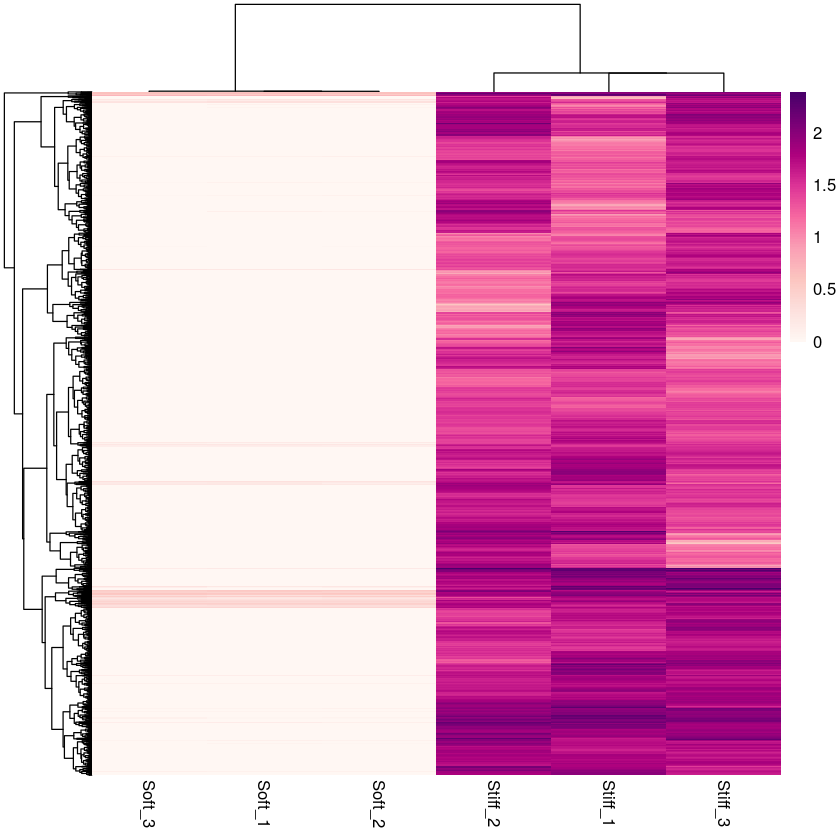

In [49]:
p1=pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='none',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3"))


In [50]:
head(rownames(forheatmap))

[1] "chr18_25731418_25731854" "chr11_30149885_30150195"
[3] "chr6_86024162_86024589"  "chr6_12175187_12175425" 
[5] "chr10_11056603_11057011" "chr19_3379971_3380212"

In [51]:
write.table(forheatmap,file="pc1.soft.stiff.highest.tsv",row.names=TRUE,col.names=TRUE,sep='\t')

## SP1 Peaks

In [52]:
strongest_sp1=read.table("../../homer//explicit_sp1_scan/sp1.txt",header=TRUE,sep='\t')


In [53]:
head(strongest_sp1)

PositionID,Offset,Sequence,Motif.Name,Strand,MotifScore
221467,-59,GGCCCCGCCCCC,Sp1(Zf)/Promoter/Homer,+,14.545522
221467,-39,AGGCCCGCCCCC,Sp1(Zf)/Promoter/Homer,+,10.792980
221467,14,AGCCCCGCCCCC,Sp1(Zf)/Promoter/Homer,+,13.450600
221467,46,AGCCCCGCCCCC,Sp1(Zf)/Promoter/Homer,+,13.450600
221467,96,CTGGGCGGAGCG,Sp1(Zf)/Promoter/Homer,-,9.031086
221467,-55,CTGGGCGGGCCC,Sp1(Zf)/Promoter/Homer,-,8.968299


In [54]:
for_heatmap=lognorm[strongest_sp1$PositionID,]

In [55]:
head(for_heatmap)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chrX_154977251_154977538,0.8798282,0.8526402,0.8903067,1.239862,0.8780744,0
chrX_154977251_154977538,0.8798282,0.8526402,0.8903067,1.239862,0.8780744,0
chrX_154977251_154977538,0.8798282,0.8526402,0.8903067,1.239862,0.8780744,0
chrX_154977251_154977538,0.8798282,0.8526402,0.8903067,1.239862,0.8780744,0
chrX_154977251_154977538,0.8798282,0.8526402,0.8903067,1.239862,0.8780744,0
chrX_154977251_154977538,0.8798282,0.8526402,0.8903067,1.239862,0.8780744,0


In [56]:
p1=pheatmap(for_heatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='row',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE,
         labels_col=c("Soft_1","Soft_2","Soft_3","Stiff_1","Stiff_2","Stiff_3"))

ERROR: Error in hclust(d, method = method): NA/NaN/Inf in foreign function call (arg 11)


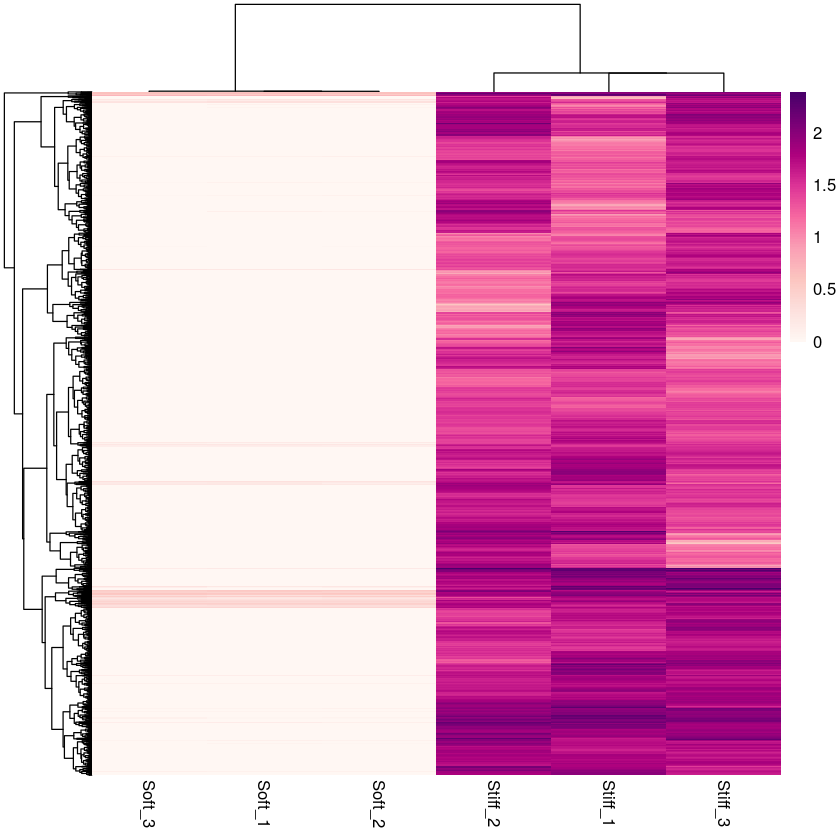

In [57]:
p1